## Import the modules

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as OPT
from torch.utils.data import random_split, DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

## Looking at the Dataset

In [113]:
df = pd.read_csv("../Datasets/fifa_data.csv")
df

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,18203,243165,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,18204,241638,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,https://cdn.sofifa.org/flags/14.png,47,67,Cambridge United,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,18205,246268,D. Walker-Rice,17,https://cdn.sofifa.org/players/4/19/246268.png,England,https://cdn.sofifa.org/flags/14.png,47,66,Tranmere Rovers,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


## Getting the Data from the csv file

In [114]:
with open("../Datasets/fifa_data.csv", encoding="cp850") as csv_file:
    csv_data = csv.reader(csv_file, delimiter=",")
    dataset = []
    first_iter = True
    
    for row in csv_data:
        if not first_iter:
            dataset.append(row)
        else:
            columns = row
            first_iter = False

## Separating the Dataset into inputs and targets

In [115]:
inputs = []
targets = []

for row in dataset:
    input_elem = []
    output_elem = []
    for i, column in enumerate(row):
        if i == 7:
            output_elem.append(column)
        elif (i==3 or i==11 or i==12) or (i>=14 and i<=18) or (i==22 or i==26 or i==27) or (i>=54 and i<=88):
            input_elem.append(column)
            
    inputs.append(input_elem)
    targets.append(output_elem)

## Modifying the Inputs and the Targets (mainly the data type)

In [116]:
foots = {"Left": 20, "Right": 10, "nan": 0}
workrates = {
    "Medium/ Medium": 2, "High/ Low": 4, "High/ Medium": 5, "High/ High": 3,
    "Medium/ High": 6, "Medium/ Low": 9, "Low/ High": 8, "Low/ Medium": 7, 
    "Low/ Low": 1, "nan": 0
    }

for i, target in enumerate(targets):
    targets[i] = [int(target[0])]

for num_row, row in enumerate(inputs):
    for i, column in enumerate(row):
        try:
            if (i==0) or (i>=4 and i<=6) or (i==8) or (i>=11 and i<=44):
                inputs[num_row][i] = int(column)
            elif (i==1) or (i==2) or (i==45):
                if (column[-1] == 'M'):
                    inputs[num_row][i] = float(column[3:-1])
                else:
                    inputs[num_row][i] = float(column[3:-1]) / 1_000
            elif (i==3):
                if (inputs[num_row][i]!=float("nan")) and (inputs[num_row][i]!=''):  
                    inputs[num_row][i] = foots[inputs[num_row][i]]
                else:
                    inputs[num_row][i] = 0
            elif (i==7):
                if (inputs[num_row][i]!=float("nan")) and (inputs[num_row][i]!=''):  
                    inputs[num_row][i] = workrates[inputs[num_row][i]]
                else:
                    inputs[num_row][i] = 0
            elif (i==9):
                inputs[num_row][i] = float('.'.join(column.split("'")))
            elif (i==10):
                inputs[num_row][i] = int(column[:-3]) / 10
        
        except (ValueError, IndexError):
            inputs[num_row][i] = 0

## Hyperparameters

In [117]:
input_size = 46
hidd1_size = 64
hidd2_size = 128
hidd3_size = 64
hidd4_size = 10
output_size = 1
train_size = 15_000
valid_size = 3_157
test_size = 50
batch_size = 128

## Creating the Data Loaders

In [7]:
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

train_ds, valid_ds, test_ds = random_split(TensorDataset(inputs_tensor, targets_tensor), [train_size, valid_size, test_size])

train_dl = DataLoader(train_ds, batch_size, num_workers=4, pin_memory=True, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

## Creating the functions that will move the Model and the Data Loaders on GPU

In [8]:
def get_default_device():
    """ Returning the GPU device if the cuda toolkit is installed on the machine, else GPU """
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data, device):
    """ Moving the specified data to the given device. If list or typle then also return them as a list """
    if isinstance(data, (list, tuple)):
        passed_list = []
        for d in data:
            passed_list.append(d.to(device, non_blocking=True))
        
        return passed_list
    return data.to(device, non_blocking=True)

class DeviceLoader:
    """ Creating a Class that will move the batches of the loader to the device on by one, not all at onve """
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device
        
    def __iter__(self):
        for batch in self.loader:
            yield to_device(batch, self.device)
            
    def __len__(self):
        return len(self.loader)

## Creating the Model

In [28]:
class FifaModel(nn.Module):
    def __init__(self, in_size, h1_size, h2_size, h3_size, h4_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, h1_size)
        self.linear2 = nn.Linear(h1_size, h2_size)
        self.linear3 = nn.Linear(h2_size, h3_size)
        self.linear4 = nn.Linear(h3_size, h4_size)
        self.linear5 = nn.Linear(h4_size, out_size)
        
    def __call__(self, inputs_batch):
        out1 = self.linear1(inputs_batch)
        out1 = F.leaky_relu(out1)
        out2 = self.linear2(out1)
        out2 = F.relu(out2)
        out3 = self.linear3(out2)
        out3 = F.leaky_relu(out3)
        out4 = self.linear4(out3)
        out4 = F.relu(out4)
        model_preds = self.linear5(out4)
        return model_preds
    
    def __validation_step(self, valid_batch):
        inputs_batch, outputs_batch = valid_batch
        model_preds = self(inputs_batch)
        loss = F.mse_loss(model_preds, outputs_batch)
        acc = 100 - torch.mean((torch.abs((outputs_batch - model_preds) / outputs_batch))).item() * 100
        return loss.sqrt().item(), acc
    
    def __validation_end(self, results):
        avg_loss = torch.tensor([x[0] for x in results]).mean().item()
        avg_acc = torch.tensor([x[1] for x in results]).mean().item()
        return {"valid_loss": avg_loss, "valid_acc": avg_acc}
    
    def training_step(self, train_batch):
        inputs_batch, outputs_batch = train_batch
        model_preds = self(inputs_batch)
        loss = F.mse_loss(model_preds, outputs_batch)
        return loss
    
    def evaluate(self, validation_loader):
        results = [self.__validation_step(valid_batch) for valid_batch in validation_loader]
        return self.__validation_end(results)
    
    def epoch_end(self, epoch, results):
        return {"Epoch": epoch+1, "Loss": results["valid_loss"], "Acc": results["valid_acc"]}
    
    def predict(self, test_parameters):
        inputs, target = test_parameters
        pred = self(inputs)
        loss = F.mse_loss(pred, target)
        acc = 100 - torch.abs((target - pred) / target).item() * 100
        return {"Loss": loss.sqrt().item(), "Acc(%)": acc, "Actual": int(target.item()), "Predicted": int(pred.item())}

## Creating a function that will plot the loss later

In [126]:
def plot(history):
    epochs = []
    losses = []
    accs = []
    for h in history:
        epochs.append(h["Epoch"])
        losses.append(h["Loss"])
        accs.append(h["Acc"])
        
    plt.figure(figsize=(5, 4), dpi=100)
        
    plt.subplot(1, 2, 1)
    plt.title("Loss", loc="center", pad=0.9, fontdict={"fontsize":14})
    plt.plot(epochs, losses, color='k')
    
    plt.subplot(1, 2, 2)
    plt.title("Accuracy", loc="center", pad=0.9, fontdict={"fontsize":14})
    plt.plot(epochs, accs, color='k')
    
    plt.suptitle("Fifa Dataset")
    
    plt.show()

## Creating the Model

In [30]:
model = FifaModel(input_size, hidd1_size, hidd2_size, hidd3_size, hidd4_size, output_size)

## Moving the Data Loaders, the Model and the test Dataset to the GPU

In [31]:
""" Getting the device object """
device = get_default_device()

""" Model parameters on GPU """
model.to(device)

""" Loaders and Datasets on GPU """
train_loader = DeviceLoader(train_dl, device)
valid_loader = DeviceLoader(valid_dl, device)
test_set_gpu = DeviceLoader(test_ds, device)

## Creating the training loop

In [32]:
def fit(model, epochs, train_loader, valid_loader, opt=OPT.SGD, lr=1e-5):
    history = []
    optim = opt(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for train_batch in train_loader:
            loss = model.training_step(train_batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
            
        valid_results = model.evaluate(valid_loader)
        epoch_result = model.epoch_end(epoch, valid_results)
        history.append(epoch_result)
        print({"Epoch": epoch+1, "Loss": valid_results["valid_loss"], "Acc(%)": valid_results["valid_acc"]})
        
    return history

## Training the Model

In [33]:
history = fit(model, 20, train_loader, valid_loader)

{'Epoch': 1, 'Loss': 7.270717144012451, 'Acc(%)': 92.28512573242188}
{'Epoch': 2, 'Loss': 4.369241714477539, 'Acc(%)': 95.06029510498047}
{'Epoch': 3, 'Loss': 3.77384877204895, 'Acc(%)': 95.94908142089844}
{'Epoch': 4, 'Loss': 3.686990976333618, 'Acc(%)': 96.02971649169922}
{'Epoch': 5, 'Loss': 3.5468227863311768, 'Acc(%)': 96.25760650634766}
{'Epoch': 6, 'Loss': 3.4784090518951416, 'Acc(%)': 96.35267639160156}
{'Epoch': 7, 'Loss': 3.383780002593994, 'Acc(%)': 96.47147369384766}
{'Epoch': 8, 'Loss': 3.405776023864746, 'Acc(%)': 96.45866394042969}
{'Epoch': 9, 'Loss': 3.2503011226654053, 'Acc(%)': 96.64677429199219}
{'Epoch': 10, 'Loss': 3.1946029663085938, 'Acc(%)': 96.71351623535156}
{'Epoch': 11, 'Loss': 3.190882682800293, 'Acc(%)': 96.7040786743164}
{'Epoch': 12, 'Loss': 3.0992987155914307, 'Acc(%)': 96.839111328125}
{'Epoch': 13, 'Loss': 3.0519297122955322, 'Acc(%)': 96.91046905517578}
{'Epoch': 14, 'Loss': 3.028782606124878, 'Acc(%)': 96.93065643310547}
{'Epoch': 15, 'Loss': 2.973

{'Loss': 1.9005775451660156, 'Acc(%)': 96.88429906964302, 'Actual': 61, 'Predicted': 62}
{'Loss': 1.9704818725585938, 'Acc(%)': 97.40726072341204, 'Actual': 76, 'Predicted': 74}
{'Loss': 2.3993377685546875, 'Acc(%)': 96.7576514929533, 'Actual': 74, 'Predicted': 71}
{'Loss': 3.358867645263672, 'Acc(%)': 94.98676471412182, 'Actual': 67, 'Predicted': 63}
{'Loss': 0.8698959350585938, 'Acc(%)': 98.44661438837647, 'Actual': 56, 'Predicted': 55}
{'Loss': 1.4841537475585938, 'Acc(%)': 97.9386754333973, 'Actual': 72, 'Predicted': 73}
{'Loss': 0.9083404541015625, 'Acc(%)': 98.43389578163624, 'Actual': 58, 'Predicted': 57}
{'Loss': 0.5248527526855469, 'Acc(%)': 99.16690038517118, 'Actual': 63, 'Predicted': 62}
{'Loss': 2.711273193359375, 'Acc(%)': 96.56800851225853, 'Actual': 79, 'Predicted': 76}
{'Loss': 0.27632904052734375, 'Acc(%)': 99.59952314384282, 'Actual': 69, 'Predicted': 69}
{'Loss': 2.7088661193847656, 'Acc(%)': 95.48522308468819, 'Actual': 60, 'Predicted': 62}
{'Loss': 4.5596466064453

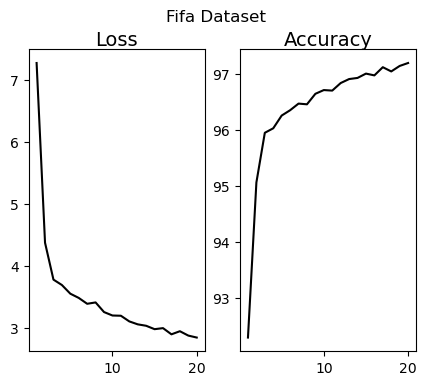

In [127]:
for t in test_set_gpu:
    print(model.predict(t))
    
plot(history)